In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

warnings.filterwarnings(action='ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
info = pd.read_csv('./building_info.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
info.describe()

,건물번호,연면적(m2),냉방면적(m2)
count,100.000000,1.000000e+02,1.000000e+02
mean,50.500000,2.608875e+05,1.864032e+05
std,29.011492,1.279963e+06,1.090638e+06
min,1.000000,5.578400e+03,0.000000e+00
25%,25.750000,6.144612e+04,2.318700e+04
50%,50.500000,9.264050e+04,5.582336e+04
75%,75.250000,1.848135e+05,9.915097e+04
max,100.000000,1.287288e+07,1.094194e+07


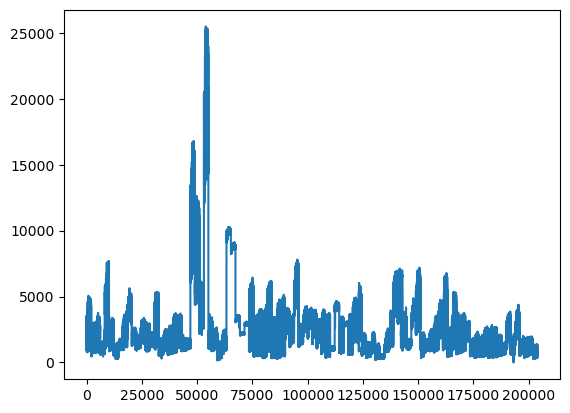

In [5]:
train_df['전력소비량(kWh)'].plot();

In [6]:
# train_df.groupby('건물번호',)[['전력소비량(kWh)']].mean().index == 1
cap = train_df.groupby('건물번호',)[['전력소비량(kWh)']].max().loc[1].values
cap

array([5063.52])

In [7]:
test_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%)
count,16800.000000,16800.000000,16800.000000,16800.000000,16800.000000
mean,50.500000,21.975232,0.266720,1.783405,77.148036
std,28.866929,2.884010,1.130288,1.041896,16.080725
min,1.000000,12.200000,0.000000,0.000000,26.000000
25%,25.750000,19.900000,0.000000,1.000000,66.750000
50%,50.500000,21.700000,0.000000,1.700000,79.000000
75%,75.250000,23.600000,0.000000,2.500000,90.000000
max,100.000000,32.300000,18.800000,7.000000,100.000000


## 가장 결과가 좋았던 외생변수 4종을 포함한 코드에 prameter 최적화를 수행한다

In [22]:
help(add_changepoints_to_plot)

Help on function add_changepoints_to_plot in module prophet.plot:

add_changepoints_to_plot(ax, m, fcst, threshold=0.01, cp_color='r', cp_linestyle='--', trend=True)
    Add markers for significant changepoints to prophet forecast plot.
    
    Example:
    fig = m.plot(forecast)
    add_changepoints_to_plot(fig.gca(), m, forecast)
    
    Parameters
    ----------
    ax: axis on which to overlay changepoint markers.
    m: Prophet model.
    fcst: Forecast output from m.predict.
    threshold: Threshold on trend change magnitude for significance.
    cp_color: Color of changepoint markers.
    cp_linestyle: Linestyle for changepoint markers.
    trend: If True, will also overlay the trend.
    
    Returns
    -------
    a list of matplotlib artists



In [18]:
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)

for i in range(1,101):
    cap = float(train_df.groupby('건물번호',)[['전력소비량(kWh)']].max().loc[i].values)
    floor = float(train_df.groupby('건물번호',)[['전력소비량(kWh)']].min().loc[i].values)
    # 한건물당 168개씩 예측한다
    sample_train = fillzero_train.loc[fillzero_train["건물번호"]==i]
    target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y','기온(C)','강수량(mm)','풍속(m/s)','습도(%)']].reset_index(drop=True)
    data['cap'] = cap
    data['floor'] = floor
    m= Prophet(
             growth= 'logistic', # 기본 linear
             # changepoints: Any = None,
             # n_changepoints: Any = 25,
             # changepoint_range: Any = 0.8,
             # yearly_seasonality: Any = 'auto',
             # weekly_seasonality: Any = 'auto',
             # daily_seasonality: Any = 'auto',
             # holidays: Any = None,
             seasonality_mode = 'additive',
             # seasonality_prior_scale: Any = 10.0,
             # holidays_prior_scale: Any = 10.0,
             # changepoint_prior_scale: Any = 0.05,
             # mcmc_samples: Any = 0,
             # interval_width: Any = 0.80,
             # uncertainty_samples: Any = 1000,
             # stan_backend: Any = None
    )
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.fit(data)

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['cap'] = cap
    future['floor'] = floor
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']

    future.loc[future.shape[0]-168:,'기온(C)'] = test_df.loc[(i-1)*168:i*168-1,'기온(C)'].values
    future.loc[future.shape[0]-168:,'강수량(mm)'] = test_df.loc[(i-1)*168:i*168-1,'강수량(mm)'].values
    future.loc[future.shape[0]-168:,'풍속(m/s)'] = test_df.loc[(i-1)*168:i*168-1,'풍속(m/s)'].values
    future.loc[future.shape[0]-168:,'습도(%)'] = test_df.loc[(i-1)*168:i*168-1,'습도(%)'].values

    forecast = m.predict(future)

    # Rest of the code



    answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

    answer["year"]=answer["num_date_time"].dt.year.astype(str)
    answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time","answer"]]
test_submission.set_index("num_date_time",inplace= True)

12:54:14 - cmdstanpy - INFO - Chain [1] start processing
12:54:15 - cmdstanpy - INFO - Chain [1] done processing
12:54:16 - cmdstanpy - INFO - Chain [1] start processing
12:54:16 - cmdstanpy - INFO - Chain [1] done processing
12:54:17 - cmdstanpy - INFO - Chain [1] start processing
12:54:18 - cmdstanpy - INFO - Chain [1] done processing
12:54:19 - cmdstanpy - INFO - Chain [1] start processing
12:54:19 - cmdstanpy - INFO - Chain [1] done processing
12:54:20 - cmdstanpy - INFO - Chain [1] start processing
12:54:20 - cmdstanpy - INFO - Chain [1] done processing
12:54:22 - cmdstanpy - INFO - Chain [1] start processing
12:54:22 - cmdstanpy - INFO - Chain [1] done processing
12:54:23 - cmdstanpy - INFO - Chain [1] start processing
12:54:23 - cmdstanpy - INFO - Chain [1] done processing
12:54:25 - cmdstanpy - INFO - Chain [1] start processing
12:54:25 - cmdstanpy - INFO - Chain [1] done processing
12:54:26 - cmdstanpy - INFO - Chain [1] start processing
12:54:26 - cmdstanpy - INFO - Chain [1]

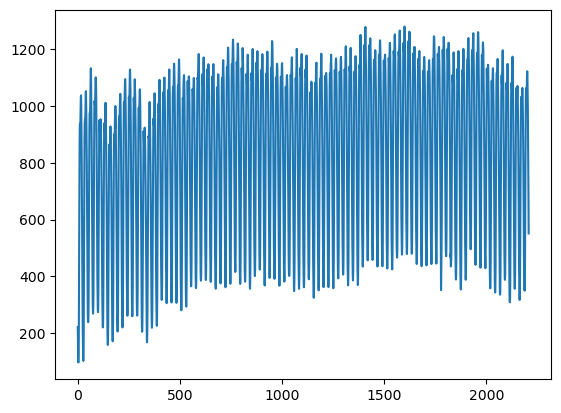

In [19]:
forecast["yhat"].plot();

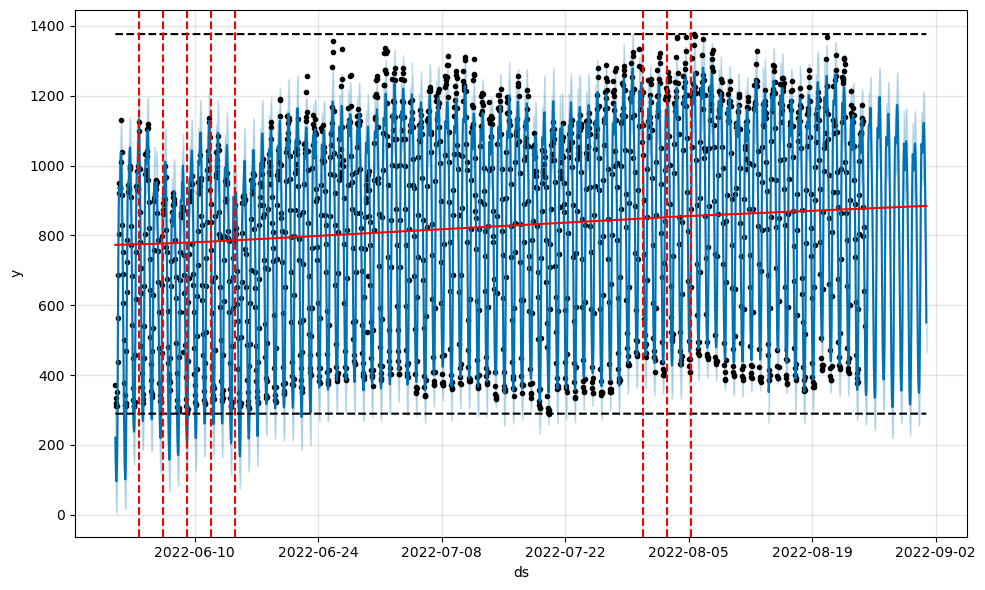

In [20]:
test_submission.to_csv("results/2023-08-13.csv")
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

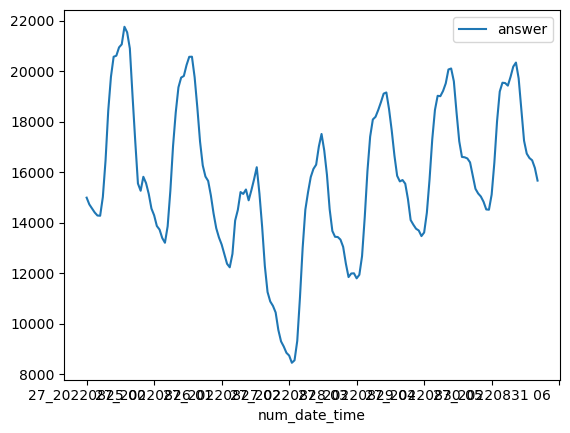

In [21]:
test_submission['num']=test_submission.index.str[:4]
test_submission.loc[test_submission['num']== '27_2'].plot();
# .groupby('건물번호',)[['전력소비량(kWh)']].max().loc[i].values

In [22]:
train_df.groupby('건물번호',)[['전력소비량(kWh)']].max() # 이상치 24,25,27번 건물 등

,전력소비량(kWh)
건물번호,
1,5063.52
2,3052.80
3,3738.60
4,1644.84
5,7694.64
...,...
96,4379.76
97,2021.04
98,1946.16


## 제출결과
1. cap, floor 설정 및 logistic 분석 실시 : 11.6409051412(2023-08-13.csv)
2.